In [1]:
import tensorflow as tf
from stardist import gputools_available
from glob import glob

from functions import *

In [2]:
pth_HE_tiles = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\training_and_testing_monkey_12_7_23\training\images'

pth_mask_tiles = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\training_and_testing_monkey_12_7_23\training\masks'

In [3]:
HE_tiles = read_tiles(pth_HE_tiles)
masks = read_masks(pth_mask_tiles)

In [4]:
ratio_validation_tiles = 0.4  # ratio of tiles that will be set aside for validation

tiles_train, masks_train, tiles_val, masks_val = split_train_val_set(HE_tiles, masks, ratio_validation_tiles)

In [5]:
# add flips and rotations to the images/masks pairs
HE_train_aug, masks_train_aug = augment_tiles(tiles_train, masks_train)

In [6]:
print(f'{len(HE_train_aug)}')
print(f'{len(masks_train_aug)}')
print(f'{len(tiles_val)}')
print(f'{(len(masks_val)}')

184
184
15
15


In [7]:
# normalize H&E images by dividing by 255
HE_train_aug= normalize_images(HE_train_aug)
tiles_val = normalize_images(tiles_val)

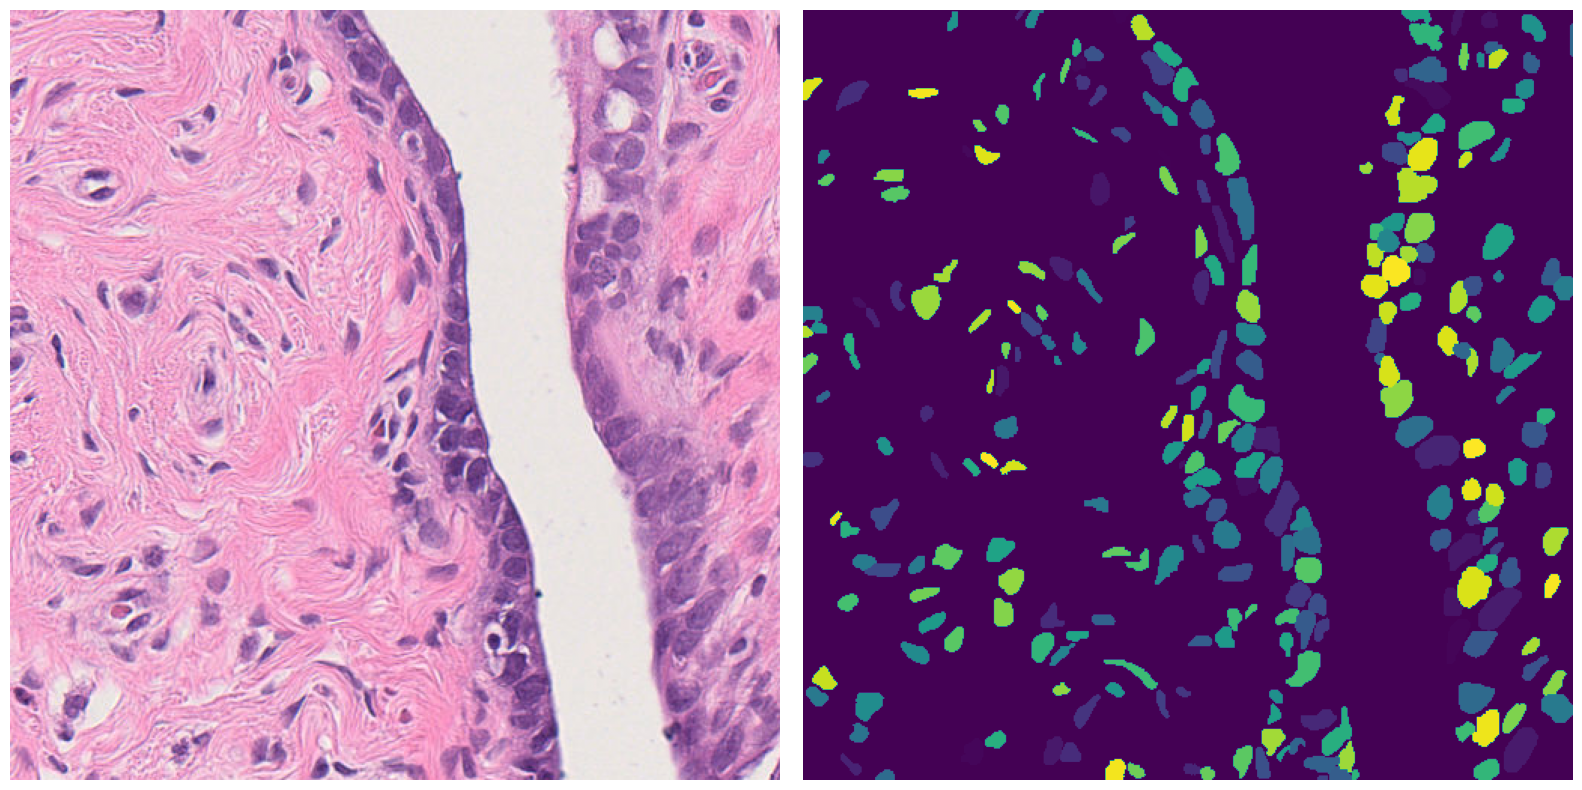

In [8]:
# look at training data
i = 50
show_HE_and_segmented(HE_train_aug[i], masks_train_aug[i])

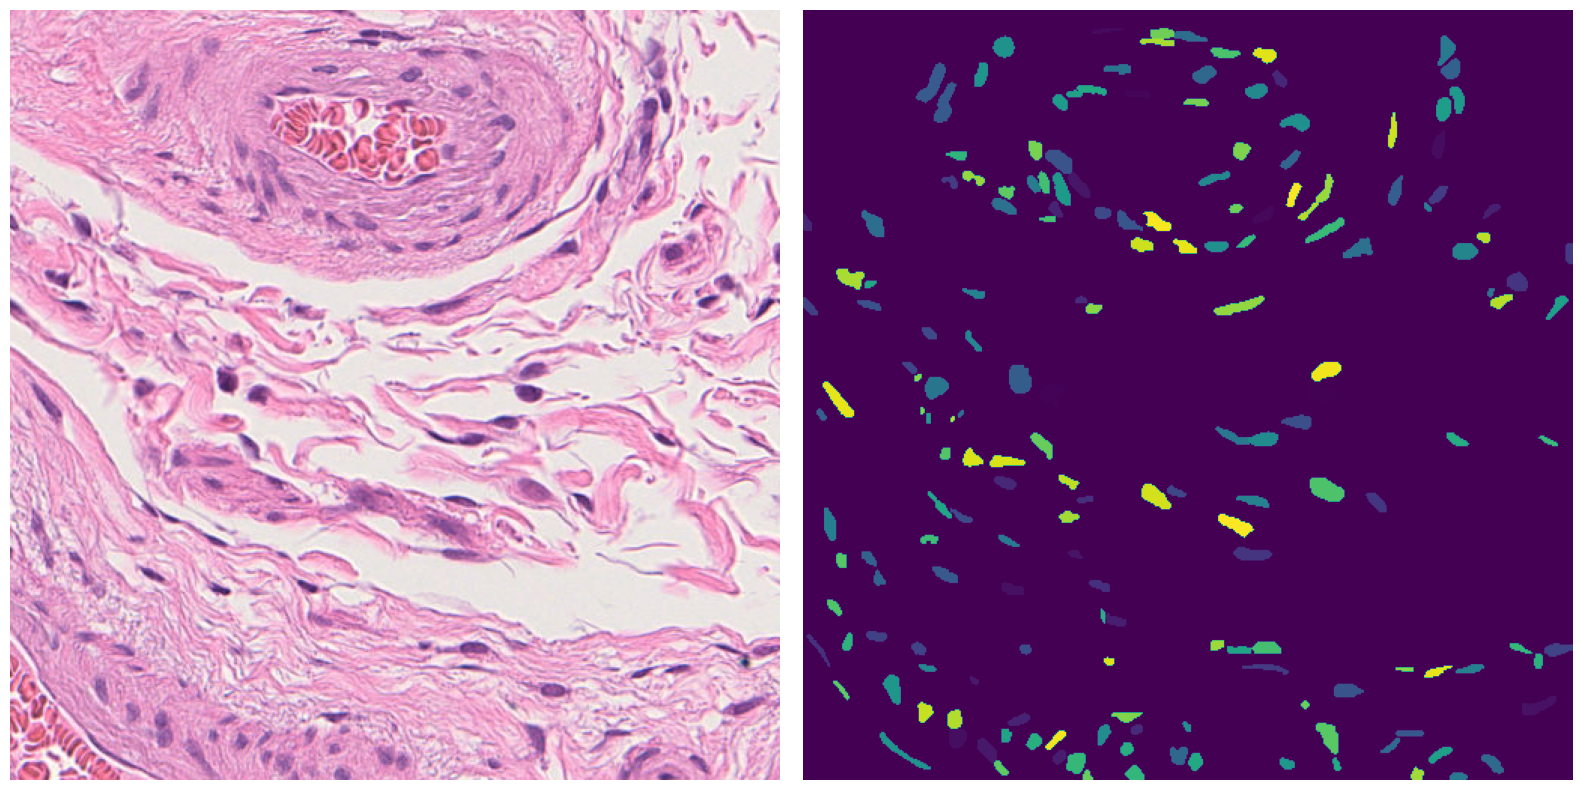

In [9]:
# look at validation
i = 4
show_HE_and_segmented(tiles_val[i], masks_val[i])

In [10]:
# config GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
print(tf.__version__)

#Define the config by setting some parameter values
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if tiles_train[0].ndim == 2 else tiles_train[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)

GPU is available
2.9.3
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [11]:
# define hyperparameters, name model
lr = 0.001
epochs = 50
patience = 40

nm='Fallopian_monkey_test_tiles'
dt='_2_20_24'
outnm = nm + dt + '_lr_' + str(lr) + '_epochs_' + str(epochs) + '_pt_' + str(patience)
print(outnm)

Fallopian_monkey_test_tiles_2_20_24_lr_0.001_epochs_50_pt_40


In [12]:
# where do you want to save the model
outpth = r'C:\Users\Donald\Downloads\temp'

In [13]:
# configure model
model = load_published_he_model(outpth, outnm)
model.config.train_learning_rate = lr
model.config.train_patch_size = (256,256)
model.config.train_reduce_lr={'factor': 0.5, 'patience': patience, 'min_delta': 0}
model.train(HE_train_aug, masks_train_aug, validation_data=(tiles_val, masks_val), epochs=epochs, steps_per_epoch=100)
model.optimize_thresholds(tiles_val, masks_val)

pth_log_train = fr"{outpth}\{outnm}\logs\train"
if not os.path.exists(pth_log_train): os.mkdir(pth_log_train)

pth_log = glob(os.path.join(pth_log_train,'*.v2'))[0]
loss = get_loss_data(str(pth_log), pth_log_train)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/50
Cause: Unable to locate the source code of <function _gcd_import at 0x0000025393E31310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000025393E31310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000025393E31310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 10s 72ms/step - loss: 0.6028 - prob_loss: 0.2565 - dist_loss: 1.7319 - prob_kld: 0.0949 - dist_relevant_mae: 1.7316 - dist_relevant_mse: 8.0854 - dist_dist_iou_metric: 0.5875 - val_loss: 0.4426 - val_prob_loss: 0.1817 - val_dist_loss: 1.3046 - val_prob_kld: 0.0665 - val_dist_relevant_mae: 1.3043 - val_dist_relevant_mse: 4.2238 - val_dist_dist_iou_metric: 0.6583 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 4s

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:03<00:01,  3.99it/s, 0.722 -> 0.656]


Using optimized values: prob_thresh=0.69732, nms_thresh=0.3.
Saving to 'thresholds.json'.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
